# ASHRAE - Great Energy Predictor III

### General Project / Past Competition Information
- Aim: (Accurately) Predicting energy consumption in commercial buildings.
- Dataset: 20 million rows, covering three years of hourly data from 2,380 meters ({0: electricity, 1: chilledwater, 2: steam, 3: hotwater}) across 1,448 commercial buildings

Possible features: ['square_feet', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
            'wind_direction', 'wind_speed', 'HDH', 'CDH', 'wind_chill_effect', 'hour', 'weekday']

Kaggle Competition link: https://www.kaggle.com/competitions/ashrae-energy-prediction/data 

### Issues & Questions
- Data size is big, not easy to process each time. Sampling?
- is there a way to cache data and not have to load it from scratch each time? should we save the random sample I selected or not?
- Should I fillna() the missing data with median etc.? - air_temperature, cloud_coverage? or dropna()?



### Ideas / Solutions:
Clarence:
- fraction by 1% or 0.5%
- aggregate data (not hourly but daily sum (for short-term), monthly sum (for longer-term) etc.) -> loss of time-series data (HVAC load may differ in a day)
- go with one building and scale up later -> may not generalize later? (instead, start with single site (same climate zone) and meter?)

Feature Engineering
- DROP COLS: floor_count remove, year_built remove it (you can sample out non missing, and then use that to subsample? but in practice). for ai. cloud_coverage drop
- IMPUTATION: precipitation -> do some imputation, explore and figure out the trend (is it dependent on other features? - linregression?) - mean/median would work. sea_level_pres (meand/meadian would be fine) and wind direction
- DROP ROWS: for dew and air temp, drop the rows only if less than 5%

- remove energy_intensity from the model in general
- monthly aggregation?

remove zeros??? - why? explanation -> operational hours, due to sensor faults / missing values
- R2 - why that low?


### Observations:
- Scatter plot (log-temp): Electricity usage depends on more than just temperature—it’s influenced by HVAC, occupancy, and operational patterns.
-  low R² (~0.14) suggests a weak linear relationship. This is expected because energy consumption is influenced by non-linear factors like HVAC control strategies, occupancy, and weather variability. -> Try tree-based models (XGBoost, Random Forest) might improve R².
- Instead of blindly dropping year_built, you could derive building_age (2025 - year_built).
For cloud_coverage, check if it correlates with energy usage before removing it.
wind_direction is cyclical (0° and 360° are the same). You might transform it into sin(wind_direction) and cos(wind_direction).



## 1. Libraries & Data Set-up

In [72]:
# !pip install pandas numpy matplotlib seaborn scikit-learn xgboost ydata-profiling

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk

from ydata_profiling import ProfileReport

In [74]:
# %pip install ipywidgets

# train_sample_9 = pd.read_csv('train_sample_9.csv')
# ProfileReport(train_sample_9).to_file("train_sample_9.html")

In [75]:
# train = pd.read_csv('/Users/meltemsahin/Documents/GitHub/ashrae-energy-prediction/data/train.csv')
# building_metadata = pd.read_csv('/Users/meltemsahin/Documents/GitHub/ashrae-energy-prediction/data/building_metadata.csv')
# weather_train = pd.read_csv('/Users/meltemsahin/Documents/GitHub/ashrae-energy-prediction/data/weather_train.csv')

# test = pd.read_csv('/Users/meltemsahin/Documents/GitHub/ashrae-energy-prediction/data/test.csv')
# weather_test = pd.read_csv('/Users/meltemsahin/Documents/GitHub/ashrae-energy-prediction/data/weather_test.csv')

In [76]:
# print("-----------\nTrain Data:")
# display(train.head())
# print(train.info())
# print(f'Size of train data: {train.shape}')
# print("-----------\nBuilding Metadata:")
# display(building_metadata.head())
# print(building_metadata.info())
# print(f'Size of building_metadata data: {building_metadata.shape}')
# print("-----------\nWeather Train Data:")
# display(weather_train.head())
# print(weather_train.info())
# print(f'Size of weather_train data: {weather_train.shape}')

# '''
# Size of train_df data (20216100, 4)
# Size of weather_train_df data (139773, 9)
# Size of weather_test_df data (277243, 9)
# Size of building_meta_df data (1449, 6)
# '''

### Merging train + building_metadata + weather_train -> **'train_merged'** (via 'building_id' and 'site_id')

In [77]:
# train_merged = pd.merge(train, building_metadata, on='building_id', how='left')
# train_merged = pd.merge(train_merged, weather_train, on=['site_id', 'timestamp'], how='left')

# display(train_merged.head()) # train + building_metadata + weather_train 

### Checking missing data (train_merged)

In [78]:
# missing_values = train_merged.isnull().sum()
# print("Missing values in each column:")
# print(missing_values[missing_values > 0])

# total = train_merged.isnull().sum().sort_values(ascending = False)
# percent = (train_merged.isnull().sum()/train_merged.isnull().count()*100).sort_values(ascending = False)
# missing__train_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent (%)'])
# missing__train_data['Percent (%)'] = missing__train_data['Percent (%)'].map('{:.2f}'.format)
# display(missing__train_data)

### Sampling (For faster processing)

In [112]:
import random
# for i in range(10):
#     sample = train_merged.sample(frac=0.05, random_state=i)
#     sample.to_csv(f'train_sample_{i}.csv', index=False)

random_sample_index = random.randint(0, 9)
train_sample = pd.read_csv(f'train_sample_{random_sample_index}.csv')
train_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010805 entries, 0 to 1010804
Data columns (total 17 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   building_id         1010805 non-null  int64  
 1   meter               1010805 non-null  int64  
 2   timestamp           1010805 non-null  object 
 3   meter_reading       1010805 non-null  float64
 4   site_id             1010805 non-null  int64  
 5   primary_use         1010805 non-null  object 
 6   square_feet         1010805 non-null  int64  
 7   year_built          404829 non-null   float64
 8   floor_count         175073 non-null   float64
 9   air_temperature     1006090 non-null  float64
 10  cloud_coverage      569199 non-null   float64
 11  dew_temperature     1005889 non-null  float64
 12  precip_depth_1_hr   823138 non-null   float64
 13  sea_level_pressure  949220 non-null   float64
 14  wind_direction      937995 non-null   float64
 15  wind_speed     

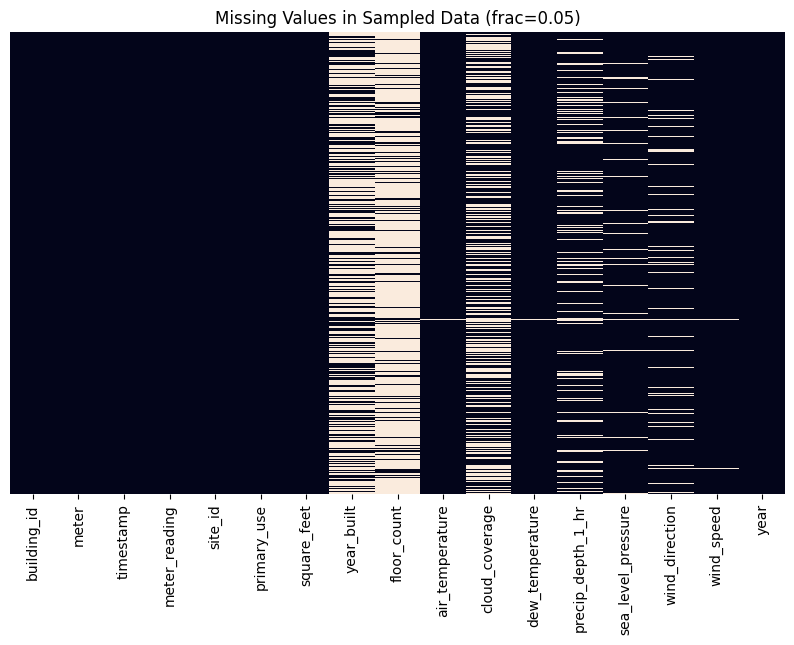

In [80]:
plt.figure(figsize=(10, 6))
sns.heatmap(train_sample.isnull(), cbar=False, yticklabels=False)
plt.title("Missing Values in Sampled Data (frac=0.05)")
plt.show()

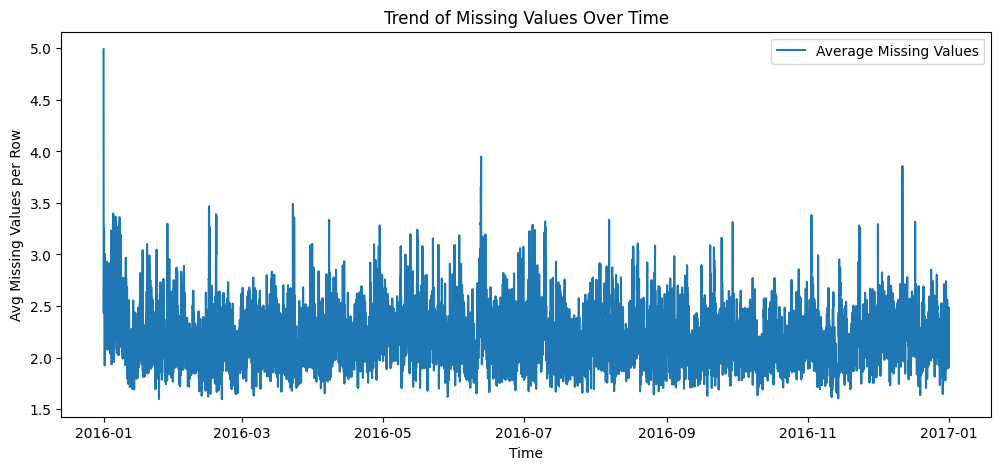

In [81]:
# Convert timestamp to datetime
train_sample['timestamp'] = pd.to_datetime(train_sample['timestamp'])

# Create a new column for missing value count
train_sample['missing_values'] = train_sample.isnull().sum(axis=1)

# Group by time to check missingness over time
missing_over_time = train_sample.groupby('timestamp')['missing_values'].mean()

# Plot missing values trend over time
plt.figure(figsize=(12, 5))
plt.plot(missing_over_time, label='Average Missing Values')
plt.xlabel('Time')
plt.ylabel('Avg Missing Values per Row')
plt.title('Trend of Missing Values Over Time')
plt.legend()
plt.show()

/var/folders/kk/rx99trsd64s0kj15czcfjmnh0000gn/T/ipykernel_31214/3969290075.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_by_use = train_sample.groupby('primary_use').apply(lambda x: x.isnull().mean() * 100)


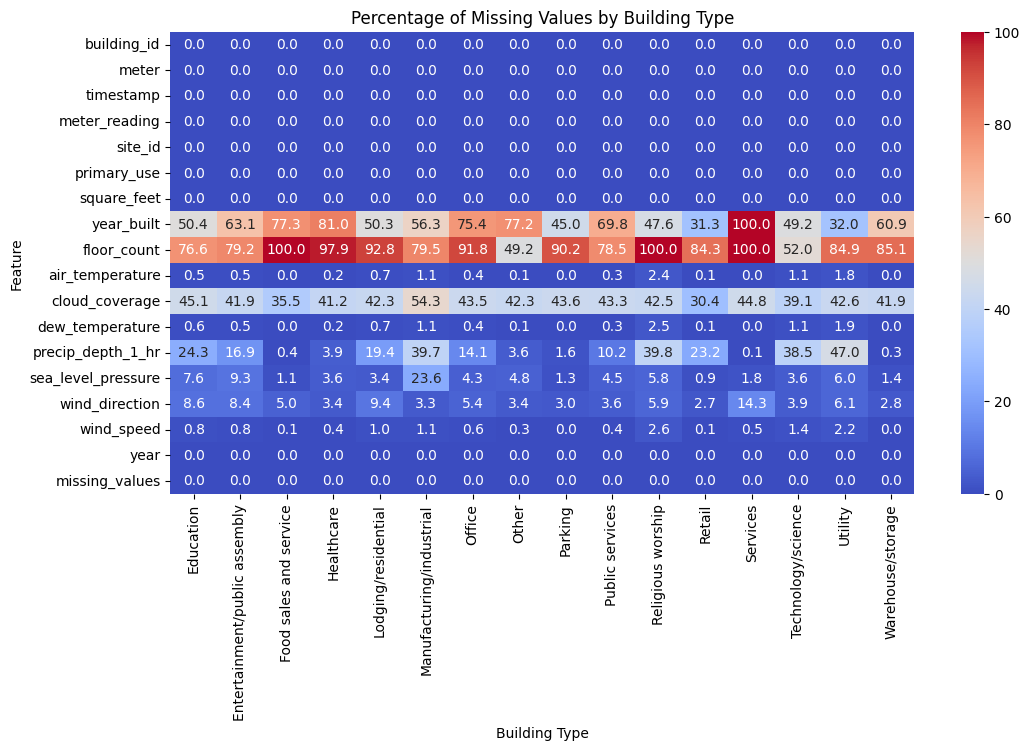

In [82]:
missing_by_use = train_sample.groupby('primary_use').apply(lambda x: x.isnull().mean() * 100)
plt.figure(figsize=(12, 6))
sns.heatmap(missing_by_use.T, cmap="coolwarm", annot=True, fmt=".1f")
plt.title('Percentage of Missing Values by Building Type')
plt.xlabel('Building Type')
plt.ylabel('Feature')
plt.xticks(rotation=90)
plt.show()

/var/folders/kk/rx99trsd64s0kj15czcfjmnh0000gn/T/ipykernel_31214/3396799336.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_by_meter = train_sample.groupby('meter').apply(lambda x: x.isnull().mean() * 100)


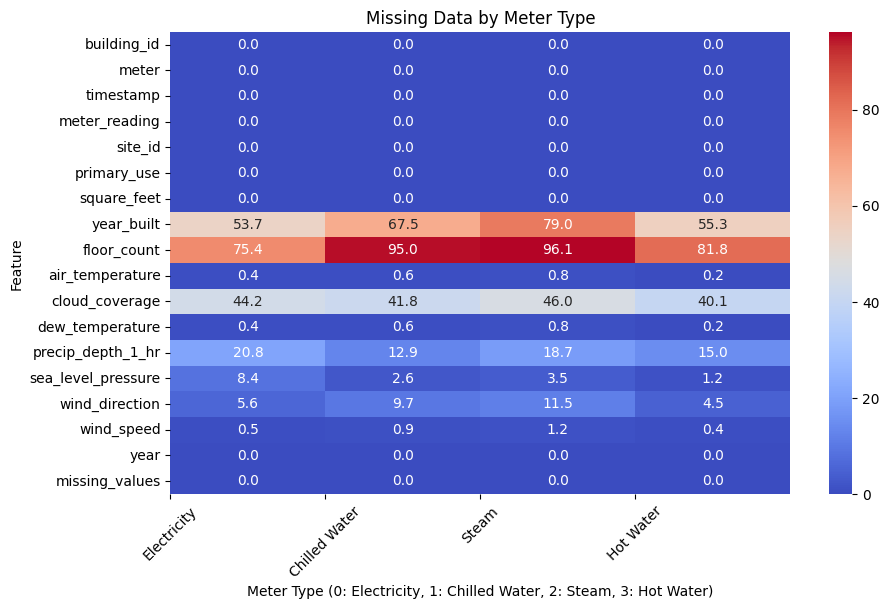

In [83]:
missing_by_meter = train_sample.groupby('meter').apply(lambda x: x.isnull().mean() * 100)

plt.figure(figsize=(10, 6))
sns.heatmap(missing_by_meter.T, cmap="coolwarm", annot=True, fmt=".1f")
plt.title('Missing Data by Meter Type')
plt.xlabel('Meter Type (0: Electricity, 1: Chilled Water, 2: Steam, 3: Hot Water)')
plt.ylabel('Feature')
plt.xticks(ticks=[0, 1, 2, 3], labels=['Electricity', 'Chilled Water', 'Steam', 'Hot Water'], rotation=45)
plt.show()

/var/folders/kk/rx99trsd64s0kj15czcfjmnh0000gn/T/ipykernel_31214/386703477.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_by_site = train_sample.groupby('site_id').apply(lambda x: x.isnull().mean() * 100)


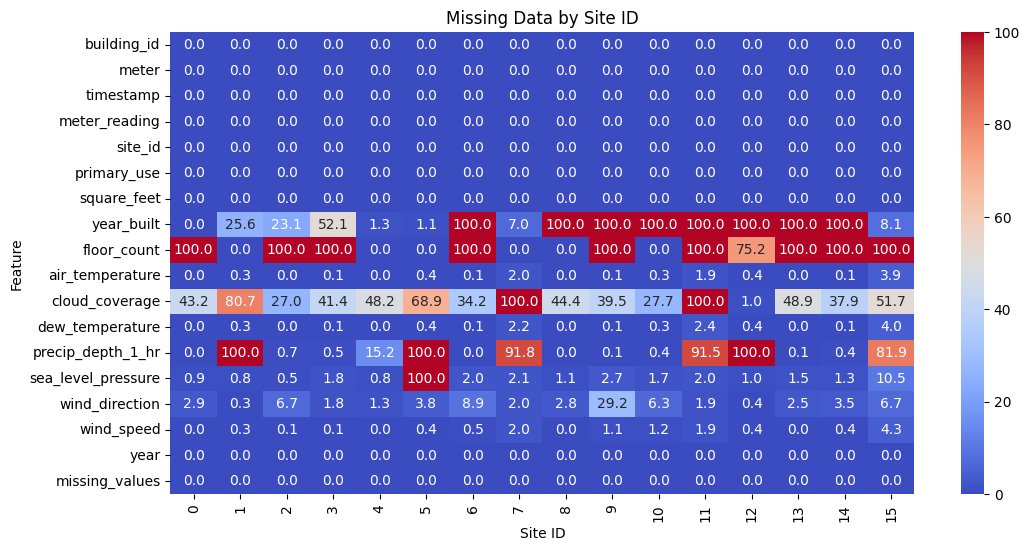

In [84]:
missing_by_site = train_sample.groupby('site_id').apply(lambda x: x.isnull().mean() * 100)

plt.figure(figsize=(12, 6))
sns.heatmap(missing_by_site.T, cmap="coolwarm", annot=True, fmt=".1f")
plt.title('Missing Data by Site ID')
plt.xlabel('Site ID')
plt.ylabel('Feature')
plt.xticks(rotation=90)
plt.show()

In [85]:
train_sample.drop(columns=['floor_count','cloud_coverage'], inplace=True)
train_sample.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,air_temperature,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,year,missing_values
0,774,1,2016-08-07 08:00:00,36.1289,6,Lodging/residential,93500,NaN,22.8,21.1,0.0,1011.5,0.0,0.0,2016,3
1,206,0,2016-10-04 14:00:00,226.2700,2,Public services,345837,1966.0,16.1,3.3,0.0,1008.8,90.0,1.5,2016,1
2,1269,0,2016-11-29 10:00:00,28.6708,14,Healthcare,56388,NaN,8.3,5.0,0.0,1016.9,100.0,2.6,2016,3
3,951,0,2016-10-10 04:00:00,113.0000,9,Office,103924,NaN,17.2,5.6,0.0,1023.4,0.0,0.0,2016,2
4,656,0,2016-05-01 21:00:00,32.7000,5,Other,5769,1976.0,11.0,10.0,NaN,NaN,300.0,2.6,2016,3


In [88]:
# impute missing values with median
train_sample['precip_depth_1_hr'].fillna(train_sample['precip_depth_1_hr'].median(), inplace=True)
train_sample['sea_level_pressure'].fillna(train_sample['sea_level_pressure'].median(), inplace=True)
train_sample['wind_direction'].fillna(train_sample['wind_direction'].median(), inplace=True)
train_sample['year_built'].fillna(train_sample['year_built'].median(), inplace=True)


train_sample.dropna(subset=['wind_speed', 'air_temperature', 'dew_temperature'], inplace=True)

/var/folders/kk/rx99trsd64s0kj15czcfjmnh0000gn/T/ipykernel_31214/1057695471.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_sample['precip_depth_1_hr'].fillna(train_sample['precip_depth_1_hr'].median(), inplace=True)
/var/folders/kk/rx99trsd64s0kj15czcfjmnh0000gn/T/ipykernel_31214/1057695471.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the inter

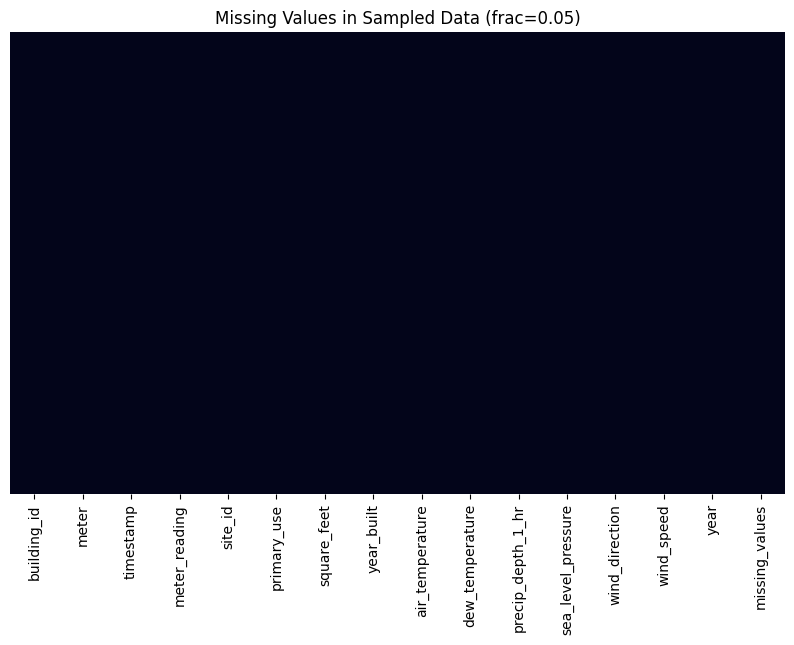

In [89]:
plt.figure(figsize=(10, 6))
sns.heatmap(train_sample.isnull(), cbar=False, yticklabels=False)
plt.title("Missing Values in Sampled Data (frac=0.05)")
plt.show()

In [13]:
# complete_buildings = train_merged.dropna()
# display(complete_buildings.head())
# print(f'Number of buildings with all features filled: {len(complete_buildings)}')

# or

# train_sample['air_temperature'].fillna(train_sample['air_temperature'].median(), inplace=True)
# train_sample['hour'] = pd.to_datetime(train_sample['timestamp']).dt.hour
# train_sample['day_of_week'] = pd.to_datetime(train_sample['timestamp']).dt.dayofweek


# or more generally:
# fillna() for numerical columns
# num_cols = ['air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr',
#             'sea_level_pressure', 'wind_direction', 'wind_speed', 'year_built']

# for col in num_cols:
#     train_sample[col].fillna(train_sample[col].median(), inplace=True)

# # dropna() floor_count (Too many missing values)
# train_sample.drop(columns=['floor_count'], inplace=True)

Check the entries where a feature is missing:

In [14]:
# cols_air_temp_missing = train_sample[train_sample['air_temperature'].isnull()]
# cols_air_temp_missing = cols_air_temp_missing.sort_values(by='building_id', ascending=False)
# cols_air_temp_missing

In [15]:
# # outlier detection
# factor = 1.5
# Q1 = train_sample['log_meter_reading'].quantile(0.25)
# Q3 = train_sample['log_meter_reading'].quantile(0.75)
# IQR = Q3 - Q1 # interquartile range 0.25-0.75
# lower_bound = Q1 - factor * IQR
# upper_bound = Q3 + factor * IQR
# train_sample = train_sample[(train_sample['log_meter_reading'] >= lower_bound) &
#                             (train_sample['log_meter_reading'] <= upper_bound)]

In [90]:
# segmentation by Meter Type:
electric_data = train_sample[train_sample['meter'] == 0]
chilled_water_data = train_sample[train_sample['meter'] == 1]
steam_data = train_sample[train_sample['meter'] == 2]
hotwater_data = train_sample[train_sample['meter'] == 3]

Building monthly meter dataset

In [91]:
# train_merged['timestamp'] = pd.to_datetime(train_merged['timestamp'])
# train_merged['year'] = train_merged['timestamp'].dt.year
# train_merged['month'] = train_merged['timestamp'].dt.month

# monthly_meter_aggregation = train_merged.groupby(['building_id', 'year', 'month'])['meter_reading'].sum().reset_index()

# monthly_meter_aggregation = pd.merge(monthly_meter_aggregation, building_metadata[['building_id', 'site_id', 'primary_use', 'square_feet', 'year_built', 'floor_count']], on='building_id', how='left')
# display(monthly_meter_aggregation.head())

Feature Selection & Engineering (year_built (building_age), air_temperature, square_feet (by energy_intensity -> meter/sqft), wind_speed?, primary_use??, hour?, weekday?)

In [92]:
thresh_temp = 18 # outside air_temp
train_sample['HDH'] = train_sample['air_temperature'].apply(lambda x: max(thresh_temp - x, 0)) # heating degree hours
train_sample['CDH'] = train_sample['air_temperature'].apply(lambda x: max(x - thresh_temp, 0)) # cooling degree days

train_sample['wind_chill_effect'] = train_sample['wind_speed'] * (thresh_temp - train_sample['air_temperature']) # + -> heat loss, - -> can work as natural cooling

train_sample['hour'] = pd.to_datetime(train_sample['timestamp']).dt.hour
train_sample['weekday'] = pd.to_datetime(train_sample['timestamp']).dt.weekday # 1,2,3,4,5,6,7

# train_sample['is_peak'] = train_sample['hour'].apply(lambda x: 1 if 7 <= x <= 19 else 0)
# train_sample['is_night'] = train_sample['hour'].apply(lambda x: 1 if x < 6 or x > 22 else 0)

train_sample['building_age'] = 2024 - train_sample['year_built']


train_sample.sort_values(by='building_id', inplace=True)
train_sample

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,air_temperature,dew_temperature,...,wind_direction,wind_speed,year,missing_values,HDH,CDH,wind_chill_effect,hour,weekday,building_age
887655,0,0,2016-09-24 14:00:00,240.944,0,Education,7432,2008.0,28.9,22.2,...,310.0,1.5,2016,1,0.0,10.9,-16.35,14,5,16.0
563619,0,0,2016-11-06 01:00:00,208.863,0,Education,7432,2008.0,20.6,14.4,...,10.0,5.1,2016,1,0.0,2.6,-13.26,1,6,16.0
267951,0,0,2016-07-19 11:00:00,297.596,0,Education,7432,2008.0,25.0,23.3,...,350.0,2.1,2016,1,0.0,7.0,-14.70,11,1,16.0
513185,0,0,2016-07-01 19:00:00,232.753,0,Education,7432,2008.0,32.8,21.1,...,290.0,3.1,2016,2,0.0,14.8,-45.88,19,4,16.0
456295,0,0,2016-06-02 05:00:00,264.833,0,Education,7432,2008.0,24.4,22.2,...,160.0,1.5,2016,1,0.0,6.4,-9.60,5,3,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165150,1448,0,2016-01-16 17:00:00,2.750,15,Office,92271,2001.0,3.9,0.0,...,270.0,5.7,2016,3,14.1,0.0,80.37,17,5,23.0
186626,1448,0,2016-05-27 09:00:00,4.250,15,Office,92271,2001.0,16.1,14.4,...,150.0,1.5,2016,2,1.9,0.0,2.85,9,4,23.0
160525,1448,0,2016-10-31 23:00:00,3.550,15,Office,92271,2001.0,0.0,-1.1,...,90.0,2.1,2016,2,18.0,0.0,37.80,23,0,23.0
638939,1448,0,2016-05-26 12:00:00,4.350,15,Office,92271,2001.0,17.8,13.3,...,70.0,1.5,2016,2,0.2,0.0,0.30,12,3,23.0


# Assignment 2

In [93]:
plt.style.use('ggplot')
color = 'darkblue'

1. Histogram - log_meter_reading distribution

In [94]:
# # remove zero meter readings???
# train_sample = train_sample[train_sample['meter_reading'] > 0]
train_sample['log_meter_reading'] = np.log1p(train_sample['meter_reading'])

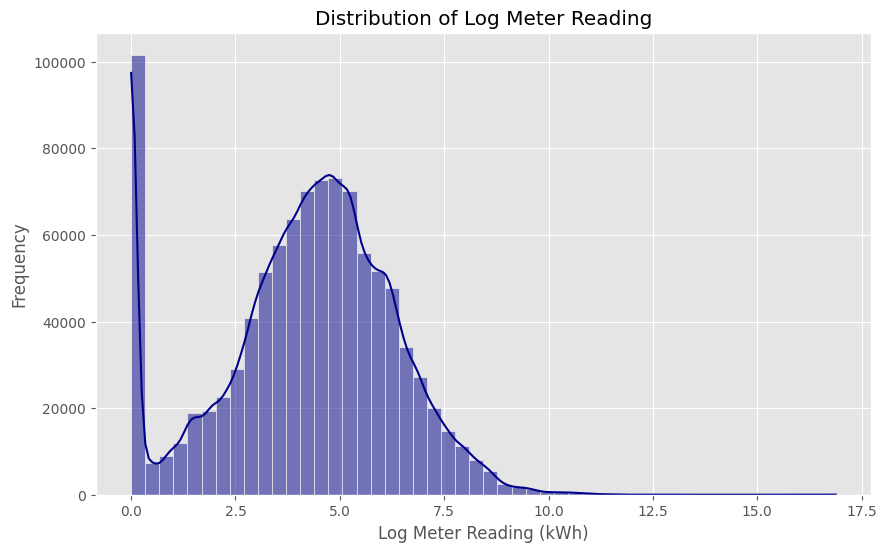

In [95]:
from matplotlib.ticker import FuncFormatter

plt.figure(figsize=(10, 6))
sns.histplot(train_sample['log_meter_reading'], bins=50 ,kde=True, color='darkblue')
plt.title('Distribution of Log Meter Reading')
plt.xlabel('Log Meter Reading (kWh)')
plt.ylabel('Frequency')

plt.show()

2. Scatter Plot - relationship bw log_meter_reading (energy use) and air_temperature

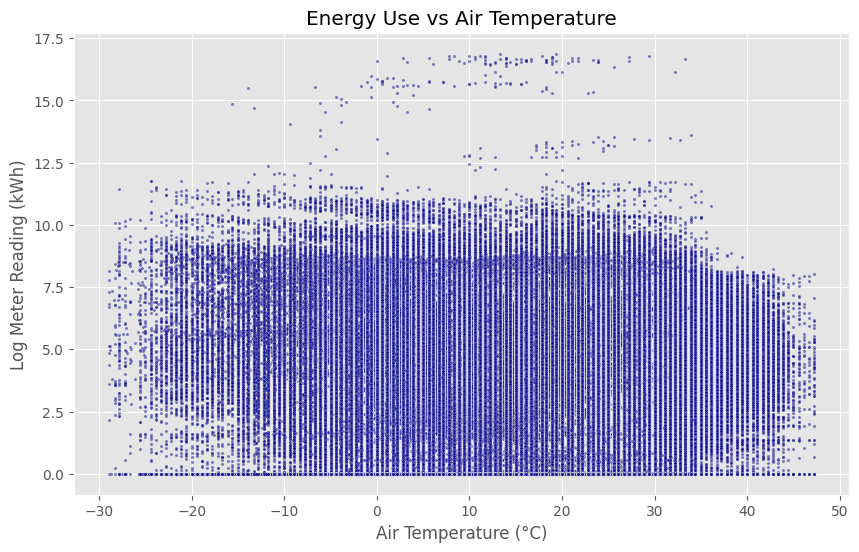

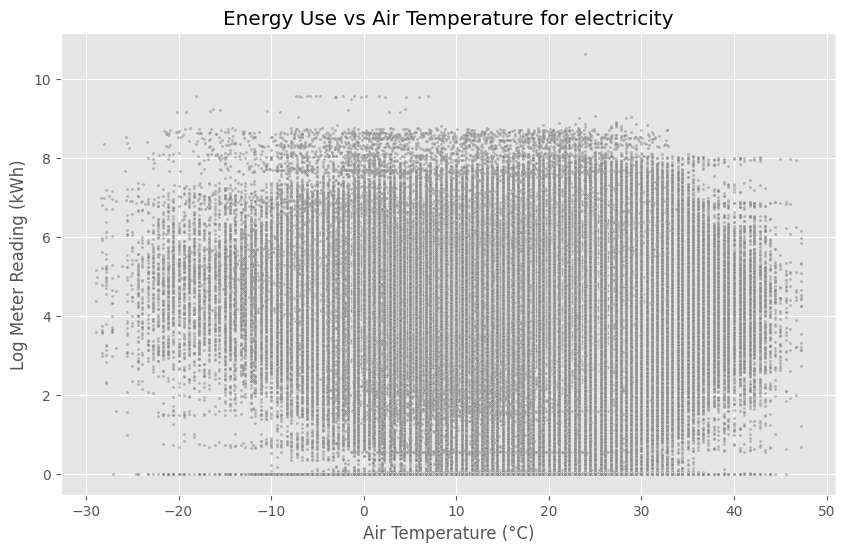

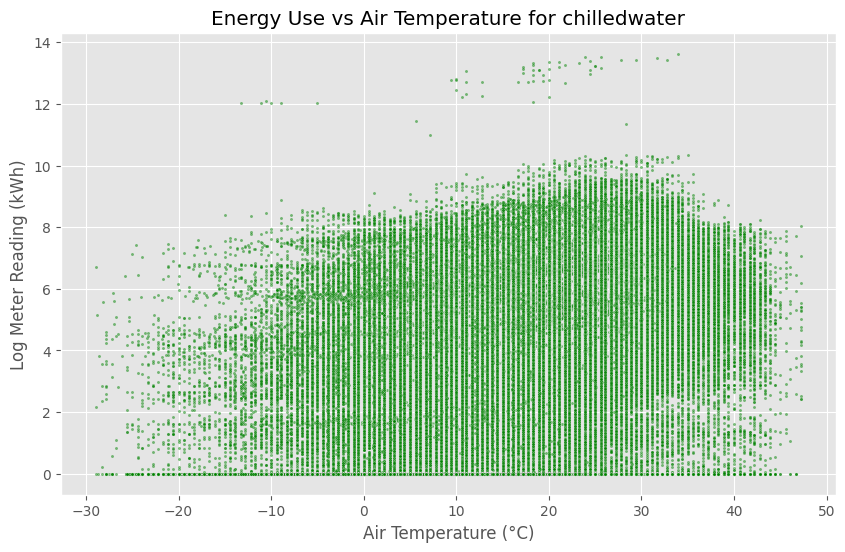

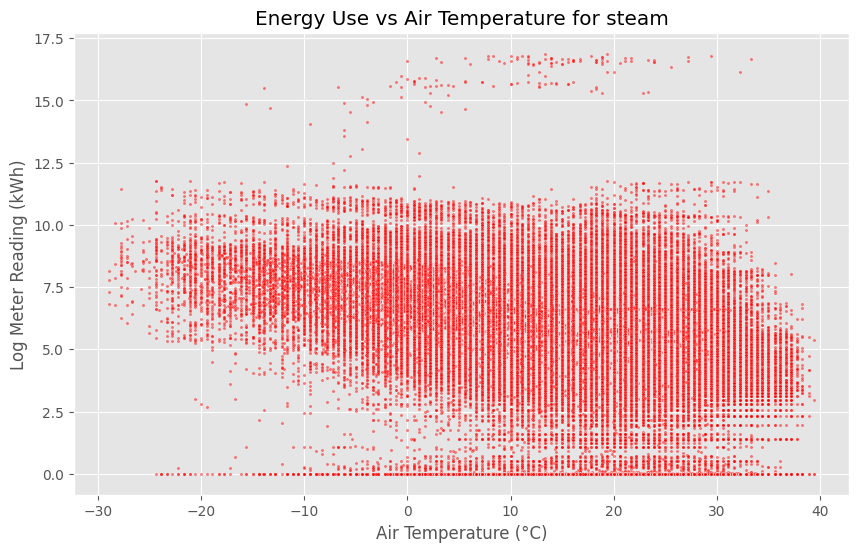

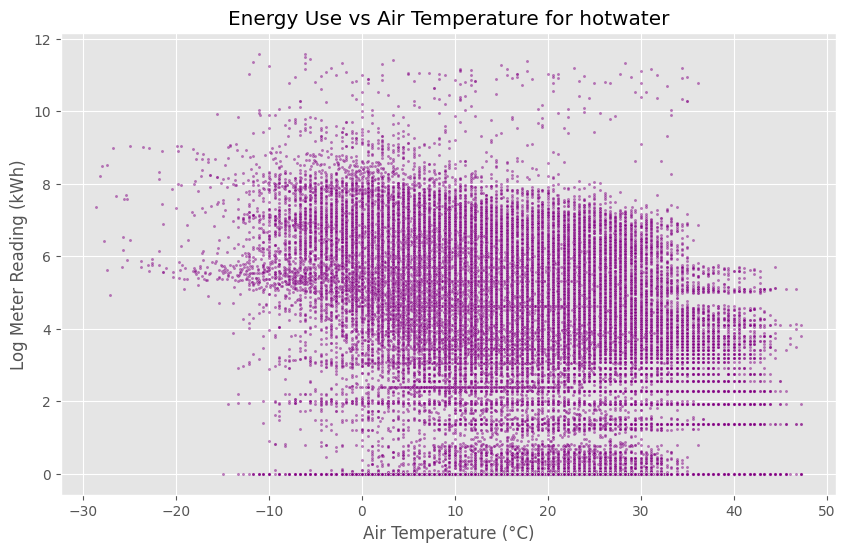

In [96]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='air_temperature', y=train_sample['log_meter_reading'], s=5, color=color, alpha=0.5, data=train_sample)
plt.xlabel('Air Temperature (°C)')
plt.ylabel('Log Meter Reading (kWh)')
plt.title('Energy Use vs Air Temperature')
plt.show()

# for different meter types
colors = {0: 'gray', 1: 'green', 2: 'red', 3: 'purple'}
meter_types = {0: 'electricity', 1: 'chilledwater', 2: 'steam', 3: 'hotwater'}

for meter_id, meter_name in meter_types.items():
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='air_temperature', y='log_meter_reading', s=5, color=colors[meter_id], alpha=0.5, data=train_sample[train_sample['meter'] == meter_id])
    plt.xlabel('Air Temperature (°C)')
    plt.ylabel('Log Meter Reading (kWh)')
    plt.title(f'Energy Use vs Air Temperature for {meter_name}')
    plt.show()

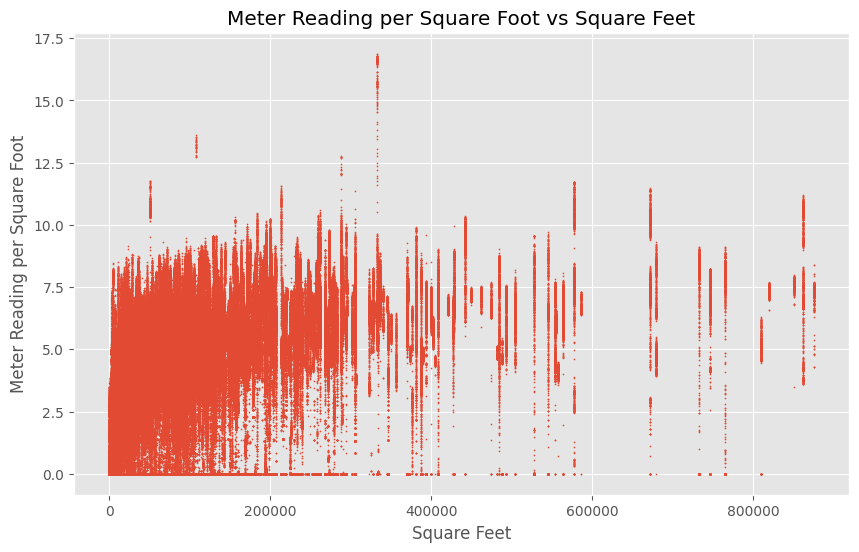

In [97]:
plt.figure(figsize=(10, 6))
plt.scatter(train_sample['square_feet'], train_sample['log_meter_reading'], s=0.5)
plt.xlabel('Square Feet')
plt.ylabel('Meter Reading per Square Foot')
plt.title('Meter Reading per Square Foot vs Square Feet')
plt.show()

Understanding zeros:

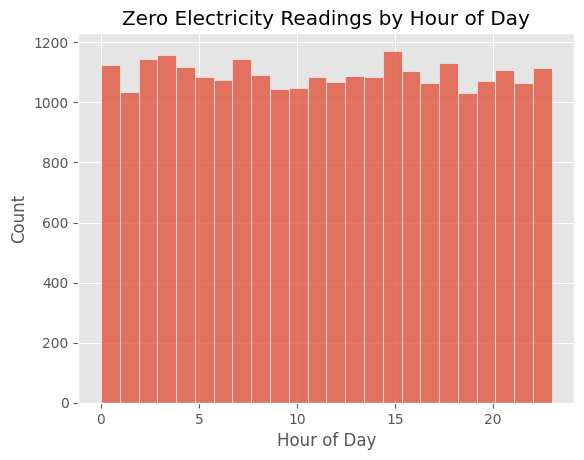

In [98]:
zero_electricity = train_sample[(train_sample['meter'] == 0) & (train_sample['meter_reading'] == 0)]
sns.histplot(zero_electricity['hour'], bins=24)
plt.title('Zero Electricity Readings by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Count')
plt.show()

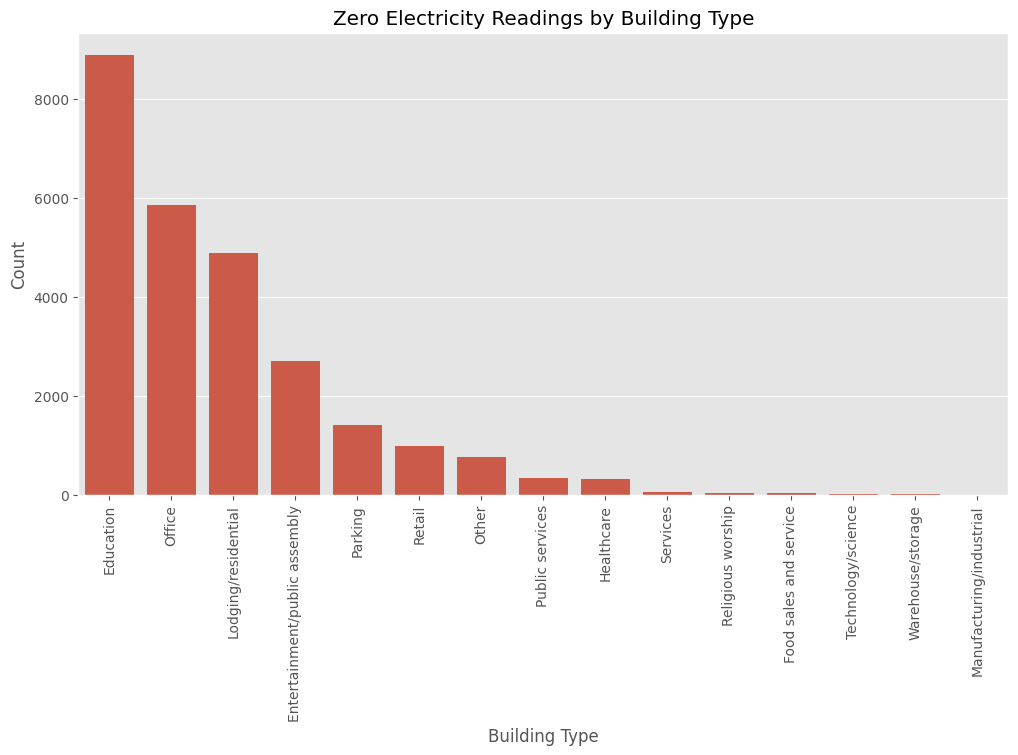

In [99]:
plt.figure(figsize=(12, 6))
sns.countplot(data=zero_electricity, x='primary_use', order=zero_electricity['primary_use'].value_counts().index)
plt.title('Zero Electricity Readings by Building Type')
plt.xlabel('Building Type')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

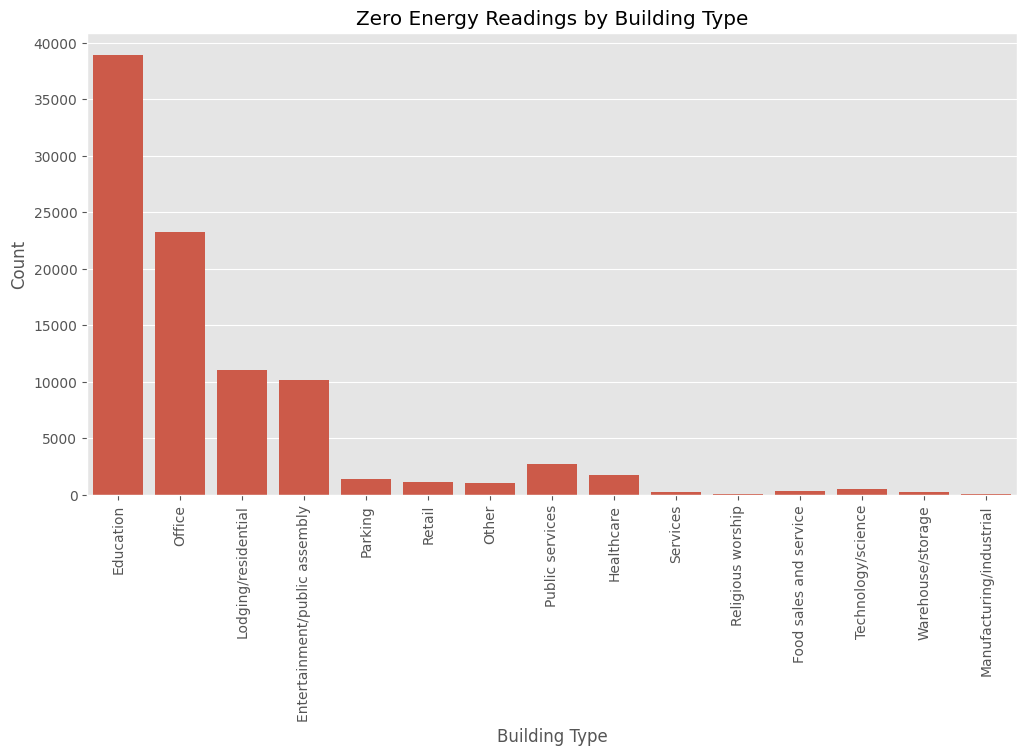

In [100]:
zero_energy = train_sample[(train_sample['meter_reading'] == 0)]

plt.figure(figsize=(12, 6))
sns.countplot(data=zero_energy, x='primary_use', order=zero_electricity['primary_use'].value_counts().index)
plt.title('Zero Energy Readings by Building Type')
plt.xlabel('Building Type')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

In [101]:
train_sample['zero_flag'] = (train_sample['meter'] == 0) & (train_sample['meter_reading'] == 0)
train_sample.groupby('building_id')['zero_flag'].mean().sort_values(ascending=False).head(10)

building_id
53      0.964286
1221    0.816038
857     0.684211
853     0.677500
1113    0.583149
815     0.526316
817     0.500000
45      0.486747
1446    0.460870
37      0.450317
Name: zero_flag, dtype: float64

3. Correlation Heatmap - relationship between air_temperature and log_meter_reading.

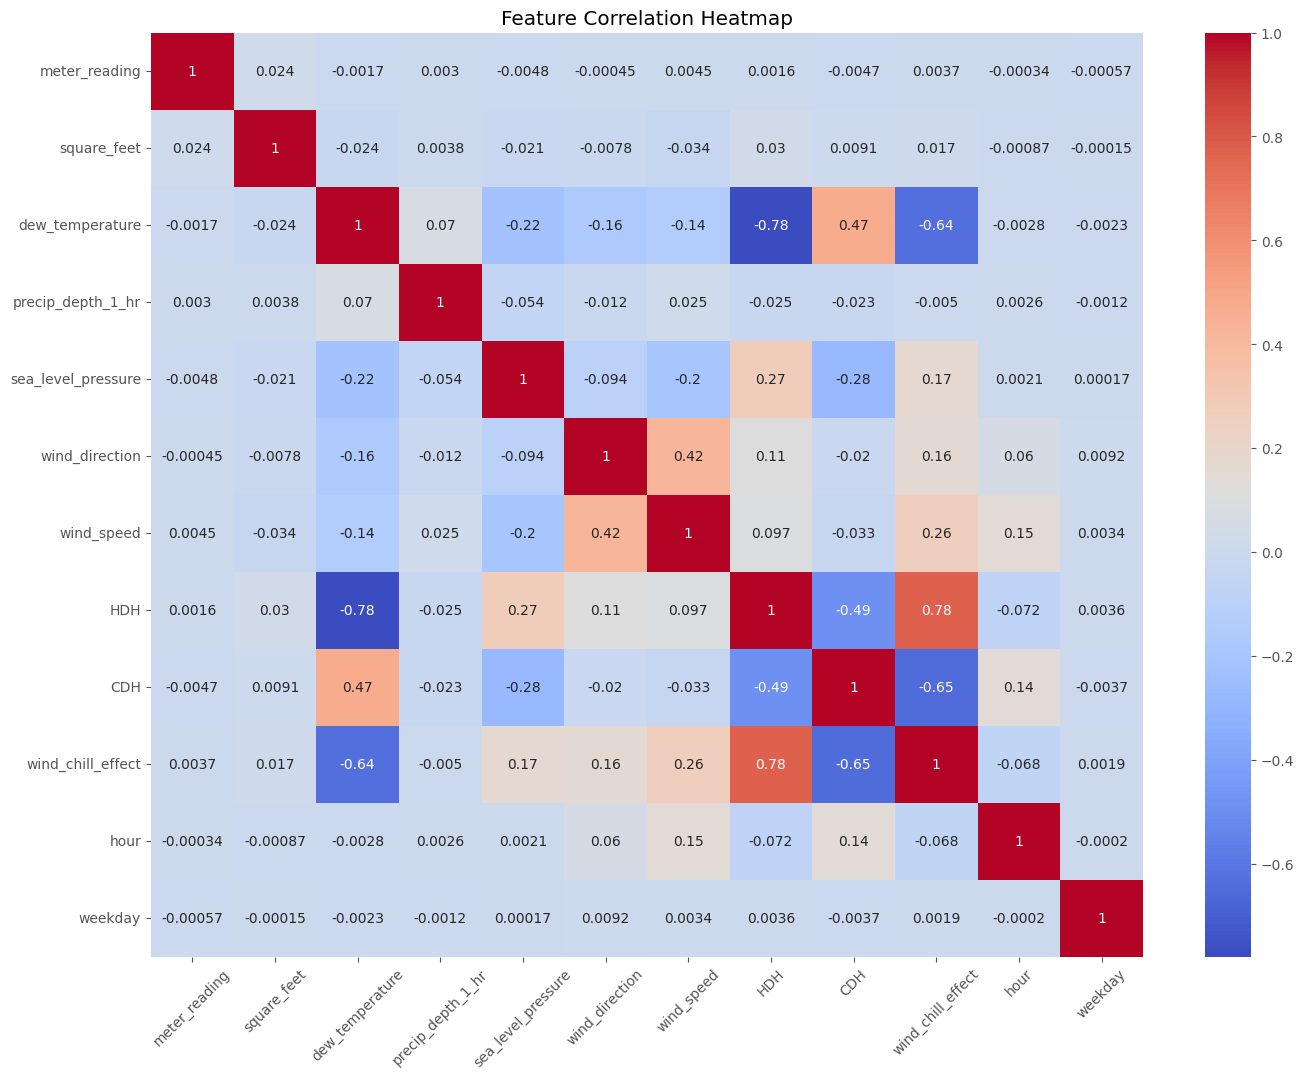

In [102]:
plt.figure(figsize=(16, 12))
corr = train_sample[['meter_reading', 'square_feet', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
                     'wind_direction', 'wind_speed', 'HDH', 'CDH', 'wind_chill_effect', 'hour', 'weekday']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.show()

## Linear Regression Model

In [103]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

features = ['square_feet', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
            'wind_direction', 'wind_speed', 'HDH', 'CDH', 'wind_chill_effect', 'hour', 'weekday']
target = 'log_meter_reading'

X = train_sample[features]
y = train_sample[target]

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Is it a right move???

In [104]:
print(X_train.isnull().sum())

X_train = X_train.dropna()
y_train = y_train[X_train.index]

X_test = X_test.dropna()
y_test = y_test[X_test.index]

print(X_train.isnull().sum())
print(X_train.info())

square_feet           0
dew_temperature       0
precip_depth_1_hr     0
sea_level_pressure    0
wind_direction        0
wind_speed            0
HDH                   0
CDH                   0
wind_chill_effect     0
hour                  0
weekday               0
dtype: int64
square_feet           0
dew_temperature       0
precip_depth_1_hr     0
sea_level_pressure    0
wind_direction        0
wind_speed            0
HDH                   0
CDH                   0
wind_chill_effect     0
hour                  0
weekday               0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 802688 entries, 416944 to 271130
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   square_feet         802688 non-null  int64  
 1   dew_temperature     802688 non-null  float64
 2   precip_depth_1_hr   802688 non-null  float64
 3   sea_level_pressure  802688 non-null  float64
 4   wind_direction      802688 non

In [105]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)

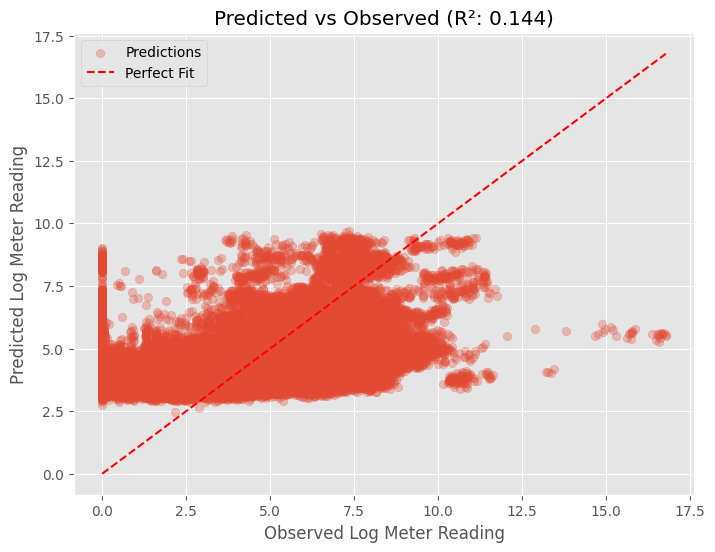

R² Score: 0.144


In [106]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.3, label="Predictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Perfect Fit")
plt.title(f'Predicted vs Observed (R²: {r2:.3f})')
plt.xlabel('Observed Log Meter Reading')
plt.ylabel('Predicted Log Meter Reading')
plt.legend()
plt.show()

print(f"R² Score: {r2:.3f}")

### Accuracy VS Complexity

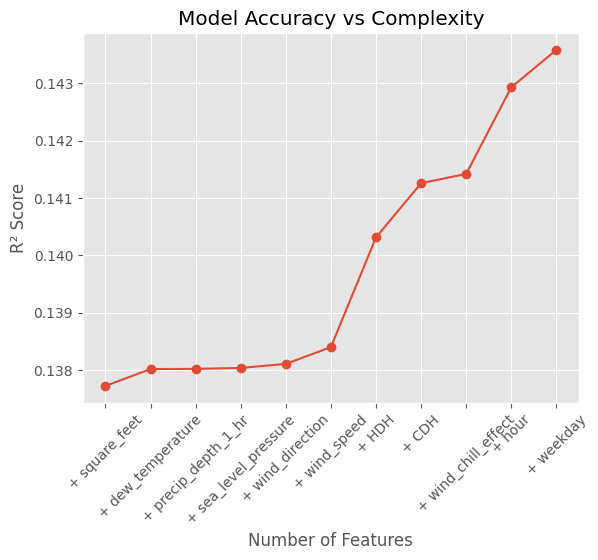

In [107]:
features = ['square_feet', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
            'wind_direction', 'wind_speed', 'HDH', 'CDH', 'wind_chill_effect', 'hour', 'weekday']
accuracy_scores = []

for i in range(1, len(features) + 1):
    selected_features = features[:i]
    X = train_sample[selected_features]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train = X_train.dropna()
    y_train = y_train[X_train.index]

    X_test = X_test.dropna()
    y_test = y_test[X_test.index]

    model = LinearRegression()
    model.fit(X_train, y_train)

    # eval accuracy
    y_pred = model.predict(X_test)
    accuracy_scores.append(r2_score(y_test, y_pred))

plt.plot(range(1, len(features) + 1), accuracy_scores, marker='o')
plt.title('Model Accuracy vs Complexity')
plt.xlabel('Number of Features')
plt.ylabel('R² Score')
plt.xticks(ticks=range(1, len(features) + 1), labels=[f'+ {feature}' for feature in features], rotation=45)
plt.show()


## 2. Exploratory Data Analysis (EDA)

In [110]:
plt.figure(figsize = (15,5))
train_merged['meter_reading'].plot()
plt.xlabel('building_id')
plt.ylabel('meter_reading (kWh)')
plt.xticks(ticks=range(0, len(train_merged['building_id']), 1_000_000), labels=range(0, len(train_merged['building_id']), 1_000_000), rotation=45)
plt.ylabel('Meter Reading (kWh)')
plt.show()


NameError: name 'train_merged' is not defined

<Figure size 1500x500 with 0 Axes>

In [24]:
sns.scatterplot(x='air_temperature', y='meter_reading', data=train_merged)
plt.title('Meter Reading vs Air Temperature')
plt.show()

NameError: name 'train_merged' is not defined

In [ ]:
log_meter_reading = np.log1p(train_merged['meter_reading'])
sns.boxplot(x='primary_use', y=log_meter_reading, data=train_merged)
plt.xticks(rotation=90)
plt.title('Log Meter Reading by Building Primary Use')
plt.show()